In [40]:
import matplotlib
from matplotlib import pyplot as plt, cm
from scipy.interpolate import griddata
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np

from Spectral_Response_of_Medium.Data.pull_data import process_df

In [41]:
#Import the LEDs and PDs being used
led_df = pd.read_csv("Data/LEDs_watch.csv")
pd_df = pd.read_csv("Data/PDs.csv")

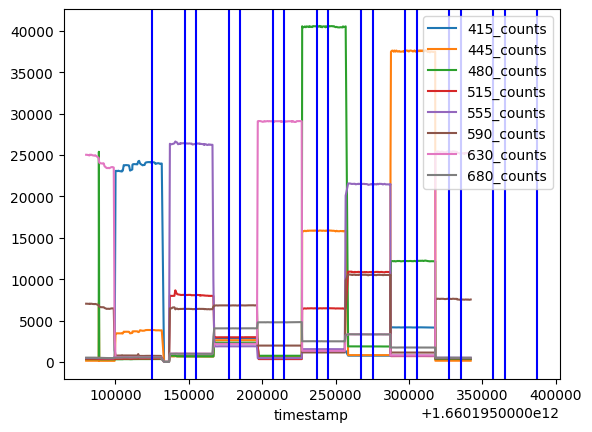

In [48]:
#Import Medium Reading and determine start and end time for each LED - This is currently hardcoded. In the future, the device will output data with a label for what LED was on at what time.
"""Replace this with whatever color you are trying to find"""
color = "blue"
medium_df = pd.read_csv("Data/Medium_Data/"+color+".csv", usecols = ['1', '2', '5'])
medium_df = process_df(medium_df)
medium_df = medium_df.sort_values('timestamp')
medium_df = medium_df.iloc[:-150]
led_order = [530,940,660,470,568,450,633,415,599]
medium_df.plot(x='timestamp', y=['415_counts','445_counts','480_counts','515_counts','555_counts','590_counts','630_counts','680_counts'])
xx=medium_df.iloc[0]['timestamp']
xx = xx + 42000
i=1

for led in led_order:
    medium_df.loc[medium_df.timestamp.between(xx+ 3000,xx+ 25000), 'LED'] = led

    plt.axvline(x=xx + 3000, color='b')
    plt.axvline(x=xx + 25000, color='b')

    xx=xx+30000
    i=i+1
plt.show()

In [49]:
# Prepare the dataframe for what we are working on
medium_df = medium_df[medium_df['LED'].notna()]
medium_df['LED'] = medium_df['LED'].astype(int)
medium_df = medium_df.drop(['timestamp'], axis=1)

final_df = pd.DataFrame()

for led in led_df.Wavelength:
    working_df = pd.DataFrame(medium_df.loc[medium_df['LED'] == (led)].mean().to_dict(),index=[medium_df.index.values[-1]])
    final_df = pd.concat([final_df, working_df], axis=0)

print(final_df.head())
final_df = final_df.drop(['LED'], axis=1)
exp_arr = final_df.to_numpy()

      415_counts    445_counts    480_counts   515_counts    555_counts  \
150   324.727273    143.727273    349.727273   431.272727    510.000000   
150  2324.970588  17696.147059   6605.882353  6186.764706  11732.823529   
150   852.805556   7845.833333  19522.472222  3235.611111    971.583333   
150  7196.171429   1420.485714    446.285714  4060.400000  13015.885714   
150  1094.064516   9531.322581  24300.774194  8315.709677  10514.419355   

      590_counts    630_counts   680_counts    LED  
150  7529.636364  25207.909091   497.181818  415.0  
150  6097.823529   2130.588235  2580.176471  450.0  
150  1579.250000  15897.305556  3705.416667  470.0  
150  3332.657143    648.285714   631.914286  530.0  
150  5363.290323   2237.193548  2870.129032  568.0  


/var/folders/49/g4x315bs2cz0g1ychp901gs40000gn/T/ipykernel_99656/3655259633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium_df['LED'] = medium_df['LED'].astype(int)


/var/folders/49/g4x315bs2cz0g1ychp901gs40000gn/T/ipykernel_99656/838109333.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


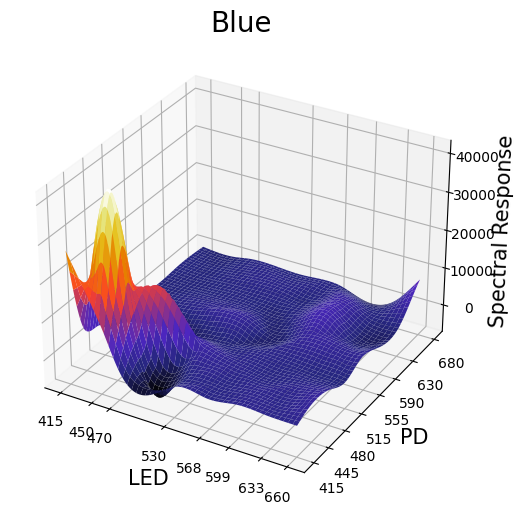

In [45]:
theory_areas = np.loadtxt('Data/Medium_Data/theory_arr.csv', delimiter = ",")
med_arr = np.subtract(exp_arr, theory_areas)
#print(med_arr)
med_arr = med_arr*-1
#print(med_arr)

fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
X = np.array(led_df.Wavelength.tolist()*len(pd_df.Wavelength.tolist()))
Y = np.array(np.repeat(pd_df.Wavelength.tolist(), len(led_df.Wavelength.tolist())))
Z = np.array([item for sublist in med_arr for item in sublist])
x_min = X.min()
x_max = X.max()
y_min = Y.min()
y_max = Y.max()
x_new = np.linspace(x_min, x_max, 600)
y_new = np.linspace(y_min, y_max, 600)

#change method: nearest, linear, cubic, etc.
z_new = griddata((X, Y), Z, (x_new[None,:], y_new[:,None]), method='cubic')

x_new_grid, y_new_grid = np.meshgrid(x_new, y_new)

surf = ax.plot_surface(x_new_grid, y_new_grid, z_new, cmap=cm.CMRmap)

ax.set_xticks(led_df.Wavelength.tolist())
ax.set_yticks(pd_df.Wavelength.tolist())

ax.set_xlabel('LED',size=15)
ax.set_ylabel('PD',size=15)
ax.set_zlabel('Spectral Response',size=15)
ax.set_title(color.capitalize(), size=20)
fig.show()

In [46]:
#Find peaks
from scipy.signal import find_peaks
z_new2 = np.ravel(z_new)
z_new2=np.array(z_new2)
y_new2 = np.ravel(y_new_grid)
y_new2=np.array(y_new2)
x_new2 = np.ravel(x_new_grid)
x_new2=np.array(x_new2)
peaks, _ = find_peaks(z_new2, prominence=(15000, 65535))

new_peaks=peaks
#print(peaks)
for i in range(0, len(peaks)):
    #print(z_new2[peaks[i]])
    if(z_new2[peaks[i]]) < 0:
        #print(peaks[i])
        z_new2 = np.delete(z_new2, int(z_new2[peaks[i]]))
        new_peaks = np.delete(peaks, i)
#print(new_peaks)

array_temp = []
array_temp_peak = []
array_temp_peak_MAX = []
array_temp_MAX = []
temp_peaks = new_peaks
value = 0

if len(temp_peaks)!=0:
    for j in range(1, len(temp_peaks)):
        #print(j)
        if z_new2[temp_peaks[j]] - z_new2[temp_peaks[j - 1]] > 0: #increasing
            array_temp.append(z_new2[temp_peaks[j - 1]])
            array_temp_peak.append(temp_peaks[j - 1])
        elif z_new2[temp_peaks[j]] - z_new2[temp_peaks[j - 1]] < 0: #decreasing
            if len(array_temp)==0:
                nothing = 0
                # skip if only decreasing from beginning. 'miss' first peak
            else:
                array_temp_MAX.append(max(array_temp))
                array_temp_peak_MAX.append(max(array_temp_peak))
                array_temp=[]
                array_temp_peak=[]

            #print(len(temp_peaks))
            #print("reset")
            if j == len(temp_peaks):
                temp_peaks=[]
            else:
                j=0
                temp_peaks = temp_peaks[j:len(temp_peaks)]

        if j == len(temp_peaks):
            temp_peaks=[]

        #print(temp_peaks)
        #print(array_temp_MAX)

# print("peak")
# print(array_temp_peak2)
# print(z_new2.max())
# print(y_new2)
print("z values MAX")
print(array_temp_MAX)
print("y values MAX")
for m in range(0, len(array_temp_peak_MAX)):
    print(y_new2[array_temp_peak_MAX[m]])
print("x values MAX")
for n in range(0, len(array_temp_peak_MAX)):
    print(x_new2[array_temp_peak_MAX[n]])

z values MAX
[42315.055219838185, 16155.680417226466]
y values MAX
444.19866444073455
477.3789649415693
x values MAX
446.49415692821367
476.7612687813022


In [47]:
#Save figure
fig.savefig("Figures/blue.pdf", bbox_inches='tight')